# CNN 설계


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

from matplotlib import pyplot as plt

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


## 하이퍼파라미터 

In [ ]:
EPOCHS     = 20
BATCH_SIZE = 32

## 데이터셋 불러오기

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,),
                                            (0.5,))])),
    batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,),
                                            (0.5,))])),
    batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified


## 모델



In [ ]:
# 미리 훈련된 ResNet 모델을 다운로드하고 불러옴
# torchvision.models 참고

import torchvision.models as models

# model = models.resnet50(pretrained=True)
# print(model) # 불러온 모델 구조 확인

class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()
      self.conv1 = nn.Conv2d(3, 32, 3)
      self.conv2 = nn.Conv2d(32, 64, 3)
      self.conv3 = nn.Conv2d(64, 64, 3)
      # self.conv4 = nn.Conv2d(64, 128, 3)
      self.conv_drop_out = nn.Dropout2d(p=0.15)
      self.fc1 = nn.Linear(256, 128)
      self.fc2 = nn.Linear(128, 64)
      self.fc3 = nn.Linear(64, 10)
      self.fc_drop_out = nn.Dropout2d(p=0.3)

    def forward(self, x):
      x = F.relu(F.max_pool2d(self.conv1(x), 2))
      x = F.relu(F.max_pool2d(self.conv_drop_out(self.conv2(x)), 2))
      x = F.relu(F.max_pool2d(self.conv_drop_out(self.conv3(x)), 2))
      # x = F.relu(F.max_pool2d(self.conv_drop_out(self.conv4(x)), 2))
      x = x.view(-1, 256)
      x = F.relu(self.fc_drop_out(self.fc1(x)))
      x = F.relu(self.fc_drop_out(self.fc2(x)))
      x = self.fc3(x)
      return x

model = Model()

In [ ]:
# 제일 마지막 FC layer를 Cifar 클래스에 맞도록 Output 크기 교체 == 즉, resnet.fc를 새로운 nn.Linear를 정의하여 할당.
# 기존 ResNet 모델 FC layer의 in_features값을 할당
#num_input을 nn.Linear에 넣고 수정

# model.fc = nn.Linear(model.fc.in_features, 10)

## 준비

In [ ]:
model.to(DEVICE)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)#0.1 vs 0.001
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## 학습하기

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

## 테스트하기

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 학습

[1] Test Loss: 1.5302, Accuracy: 45.17%
[2] Test Loss: 1.2598, Accuracy: 55.49%
[3] Test Loss: 1.1439, Accuracy: 59.36%
[4] Test Loss: 1.0231, Accuracy: 63.65%
[5] Test Loss: 0.9820, Accuracy: 66.38%
[6] Test Loss: 0.8669, Accuracy: 70.15%
[7] Test Loss: 0.8492, Accuracy: 70.63%
[8] Test Loss: 0.8305, Accuracy: 71.28%
[9] Test Loss: 0.8264, Accuracy: 71.57%
[10] Test Loss: 0.8109, Accuracy: 71.72%
[11] Test Loss: 0.8005, Accuracy: 72.29%
[12] Test Loss: 0.7995, Accuracy: 72.35%
[13] Test Loss: 0.7977, Accuracy: 72.37%
[14] Test Loss: 0.7976, Accuracy: 72.38%
[15] Test Loss: 0.7960, Accuracy: 72.45%
[16] Test Loss: 0.7949, Accuracy: 72.46%
[17] Test Loss: 0.7946, Accuracy: 72.47%
[18] Test Loss: 0.7945, Accuracy: 72.50%
[19] Test Loss: 0.7943, Accuracy: 72.52%
[20] Test Loss: 0.7942, Accuracy: 72.47%


(0.0, 100.0)

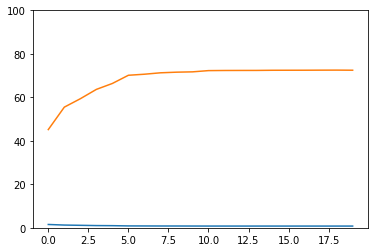

In [ ]:
loss = []
accuracy = []
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    scheduler.step()
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    loss.append(test_loss)
    accuracy.append(test_accuracy)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
plt.plot(loss)
plt.plot(accuracy)
plt.ylim(0, 100)

Text(0, 0.5, 'Accuracy')

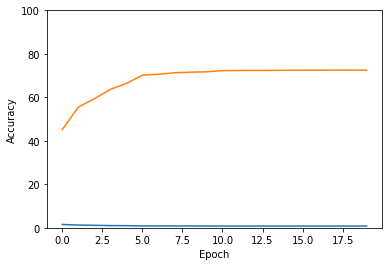

In [ ]:
plt.plot(loss)
plt.plot(accuracy)
plt.ylim(0, 100)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')